In [39]:
import glob
import os

from ficus import FigureManager
import numpy as np
import pandas as pd
import seaborn as sns

## Results: Figure 1

In [49]:
files = sorted(glob.glob('../results/chap1/SAM*.curl.txt'))
samples = set([os.path.basename(f).split('.')[0] for f in files])

In [53]:
def get_diffs(df):
    return pd.DataFrame({'d_t': df['elapsed_s'][1:].values - df['elapsed_s'][:-1].values,
                         'd_bytes': df['bytes_read'][1:].values - df['bytes_read'][:-1].values,
                         't': df['elapsed_s'][1:]})

In [110]:
stream_df = []
for accession in samples:
    print(f'Reading {accession}...')
    left_fn = f'../results/chap1/{accession}.1.curl.txt'
    right_fn = f'../results/chap1/{accession}.2.curl.txt'
    ldf = get_diffs(pd.read_table(left_fn, delim_whitespace=True, names=['elapsed_s', 'bytes_read']))
    rdf = get_diffs(pd.read_table(right_fn, delim_whitespace=True, names=['elapsed_s', 'bytes_read']))
    
    bins = list(range(0, int(max(ldf.t.max(), rdf.t.max())), 5))
    
    ldf = ldf.groupby(pd.cut(ldf.t, labels=bins[1:], bins=bins)).mean()
    ldf['bytes/s'] = ldf.d_bytes / ldf.d_t
    rdf = rdf.groupby(pd.cut(rdf.t, labels=bins[1:], bins=bins)).mean()
    rdf['bytes/s'] = rdf.d_bytes / rdf.d_t
    
    df = pd.DataFrame({'t': ldf.index,
                       'bytes/s': ldf['bytes/s'] + rdf['bytes/s'],
                       'accession': accession})
    df['MiB/s'] = df['bytes/s'] / 1048576

    stream_df.append(df.copy())
stream_df = pd.concat(stream_df).reset_index(drop=True)

Reading SAMEA3894957...
Reading SAMN04349088...
Reading SAMN10537738...
Reading SAMN04088456...
Reading SAMN09758735...
Reading SAMEA4064425...
Reading SAMN10520155...
Reading SAMN04126864...
Reading SAMEA104703328...
Reading SAMEA4774291...
Reading SAMEA3176945...


In [121]:
stream_df.head()

,t,bytes/s,accession,MiB/s
0,5,1.888283e+04,SAMEA3894957,0.018008
1,10,1.264188e+06,SAMEA3894957,1.205623
2,15,1.383822e+06,SAMEA3894957,1.319715
3,20,1.718212e+06,SAMEA3894957,1.638615
4,25,1.904960e+06,SAMEA3894957,1.816712


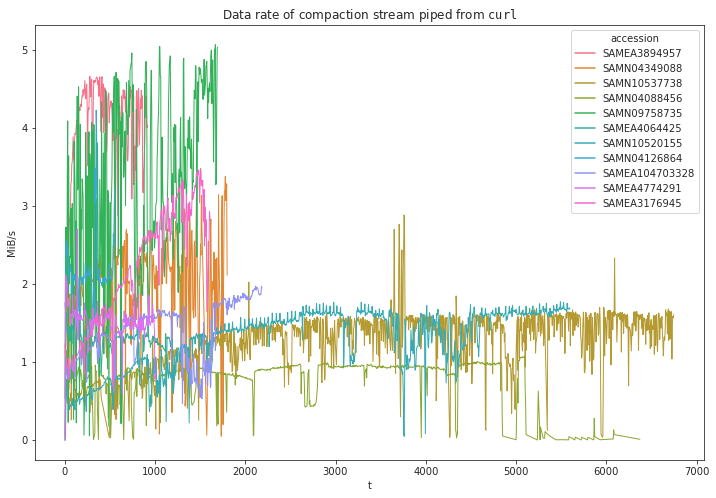

In [120]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    
    sns.lineplot(data=stream_df, x='t', y='MiB/s', hue='accession', lw=1, legend=True, ax=ax)
    ax.set_title('Data rate of compaction stream piped from $\mathtt{curl}$')

## Results: Figure 2

In [126]:
files = sorted(glob.glob('../results/chap1/cdbg-stream/*/goetia.cdbg.stats.json'))
samples = set([f.split('/')[4] for f in files])

In [169]:
def normalize_metrics(data):
    df['t_norm'] = df['t'] / df['t'].max()

    cdbg_cols =['n_full', 'n_tips', 'n_islands', 'n_trivial', 'n_circular']
    for col in cdbg_cols:
        data[col + '_p'] = data[col] / data['n_unodes']
    data['dnode_p'] = data['n_dnodes'] / (data['n_unodes'] + data['n_dnodes'])
    data['kmer_p'] = data['n_unique_kmers'] / data['n_unique_kmers'].max()
    prop_cols = [col + '_p' for col in cdbg_cols] + [ 'kmer_p']
    
    return data, prop_cols

In [170]:
metrics_df = []
for f in files:
    print(f)
    try:
        df = pd.read_json(f)
        df, prop_cols = normalize_metrics(df)
    except ValueError:
        pass
    else:
        df['t_norm'] = df['t'] / df['t'].max()
        metrics_df.append(df)
metrics_df = pd.concat(metrics_df).reset_index(drop=True)
metrics_df['sample_name'] = metrics_df.sample_name.str.rpartition('.')[0]

../results/chap1/cdbg-stream/SAMEA103927134/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA104703328/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA2747216/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA3176945/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA3894957/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA4064425/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA4774291/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA4791499/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMEA6498954/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN03002991/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04088456/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04126864/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN04349088/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN05991912/goetia.cdbg.stats.json
../results/chap1/cdbg-stream/SAMN09758735/goetia.cdbg.stats.json
../results/chap1/cdbg

In [171]:
metrics_df.head()

,t,seq_t,rt_elapsed_interval,rt_elapsed_total,sample_name,n_full,n_tips,n_islands,n_trivial,n_circular,...,n_unique_kmers,estimated_fp,t_norm,n_full_p,n_tips_p,n_islands_p,n_trivial_p,n_circular_p,dnode_p,kmer_p
0,5000135,52633,13.163505,13.163891,SAMEA103927134,12478,13035,18413,2689,0,...,2681613,0,0.013191,0.267642,0.279589,0.394942,0.057677,0.000000,0.305259,0.044804
1,10000270,105266,2.931621,16.095590,SAMEA103927134,25583,26472,29874,5272,0,...,4795154,0,0.026383,0.293322,0.303515,0.342521,0.060446,0.000000,0.323797,0.080116
2,15000310,157898,2.693477,18.789150,SAMEA103927134,39357,40320,38539,8072,1,...,6673528,0,0.039574,0.311576,0.319199,0.305100,0.063903,0.000008,0.336241,0.111500
3,20000350,210530,2.891793,21.681015,SAMEA103927134,54170,54556,44781,11046,2,...,8348020,0,0.052765,0.329127,0.331472,0.272081,0.067113,0.000012,0.346137,0.139477
4,25000485,263163,2.721536,24.402633,SAMEA103927134,69029,67612,49965,14215,2,...,9888165,0,0.065956,0.343671,0.336616,0.248758,0.070771,0.000010,0.353252,0.165209


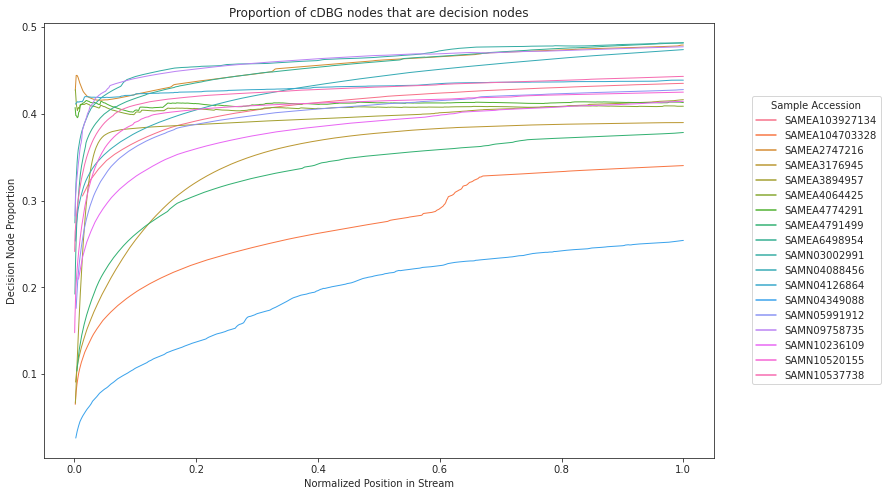

In [173]:
with sns.axes_style("ticks"), \
     FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    
    sns.lineplot(data=metrics_df, x='t_norm', y='dnode_p', hue='sample_name', lw=1, ax=ax)
    ax.set_ylabel('Decision Node Proportion')
    ax.set_xlabel('Normalized Position in Stream')
    ax.legend(bbox_to_anchor=(1.05, .5), loc='center left', title='Sample Accession')
    ax.set_title('Proportion of cDBG nodes that are decision nodes')

In [153]:
fig.legend

<bound method Figure.legend of <Figure size 864x576 with 1 Axes>>